# Binary classifier to predict in-hospital mortality


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer #, Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import *
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(missing_values=np.nan, strategy='median') # mean median.
from xgboost import XGBClassifier
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
## Part 1. Define classes and methods for the machine learning pipieline


In [4]:
unseen_label = "__New__"
seed = 200

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.le = LabelEncoder()
        self.lb = LabelBinarizer()
        self.seen_labels = set()
        
    def fit(self, x, y=None,**fit_params):
        self.seen_labels = set(x)
        self.seen_labels.add(unseen_label)
        
        # add "unseen" to X
        x_new = list(x)
        x_new.append(unseen_label)

        label_encoded = self.le.fit_transform(x_new)
        self.lb.fit(label_encoded)
        return self
    
    def transform(self, x):
        x_new = list(map(lambda label: label if label in self.seen_labels else unseen_label, list(x)))
        label_encoded = self.le.transform(x_new)
        return self.lb.transform(label_encoded)
    
    
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

    
class MultiItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key_list):
        self.key_list = key_list

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key_list]

In [5]:
def evaluate(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)   
    print ("Accuracy : {:.4f}".format(acc))
    print("AUC score : {:.4f}".format(auc))
    print("Precision : {:.4f}".format(precision))
    print("Recall : {:.4f}".format(recall))
    print("F1 score : {:.4f}".format(f1score))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
    return acc, auc, precision, recall, f1score

In [6]:
def train_evaluate_model(df):
    
    # split data into 80% training set, 20% test set
    train_cv_df = df.sample(frac=0.8, random_state=seed)
    test_df = df.drop(train_cv_df.index)
    print(df.shape, train_cv_df.shape, test_df.shape)

    # define the machine learning pipeline
    discrete_pipeline = Pipeline([
        ("feature_union", FeatureUnion(
            transformer_list=[
                # categorical pipeline
                ('ethnicity', Pipeline([
                    ("selector", ItemSelector(key='ethnicity')),
                    ("binarizer", CustomLabelBinarizer())
                ])),            
                ("gender", Pipeline([
                    ("selector", ItemSelector(key='gender')),
                    ("binarizer", CustomLabelBinarizer())
                ])),
                ("admission_type", Pipeline([
                    ("selector", ItemSelector(key='admission_type')),
                    ("binarizer", CustomLabelBinarizer())
                ])),

                # numerical pipeline
                ("numerical", Pipeline([
                    ("selector", MultiItemSelector(key_list=
                          ['age', 'icustay_num',
                           'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                           'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                           'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                           'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                           'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                           'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                           'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                           'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                           'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                           'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                           'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                           'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                           'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                           'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                           'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                           'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                           'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                           'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                           'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                           'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                           'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                           'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                           'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                           'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                           'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                           'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                           'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                           'urineoutput'])),
                    # impute missing values with median
                    #("imputer", Imputer(strategy="median",
                    #                          axis=0)),
                    
                    ("imputer", SimpleImputer(missing_values=np.nan, strategy='median')),
                    
                    
                ]))
            ]
        )),
        #("algorithm", RandomForestClassifier(n_jobs=-1)) # change it here.
        ("algorithm", XGBClassifier(n_jobs=-1))    # XGBRegressor
    ])
    
    # define the parameter grid
#    parameters = {'algorithm__n_estimators': [100, 250, 500],
#                  'algorithm__max_features': ["auto", "sqrt", "log2"],
#                  "algorithm__criterion": ["gini", "entropy"],
#                  "algorithm__max_depth": [5, 10, 30],
#                  "algorithm__bootstrap": [True, False]}

    parameters = {'algorithm__n_estimators': [500],
                  'algorithm__max_features': ["auto"],
                  "algorithm__criterion": ["gini"],
                  "algorithm__max_depth": [30],
                  "algorithm__bootstrap": [True]}
        
    # grid search on 5-fold CV, trained on 80% training set
    grid_search = GridSearchCV(discrete_pipeline, parameters, n_jobs=-1, verbose=0, refit=True, cv=5, scoring='roc_auc')
    grid_search.fit(train_cv_df, train_cv_df.hospital_expire_flag)

    # retrieve the best parameter set from grid search
    print("\nGrid Search Best parameters set :")
    print(grid_search.best_params_)
    print("\nBest score: %0.3f" % grid_search.best_score_)
    
    # print test score on each fit
#     print("\nGrid scores :")
#     means = grid_search.cv_results_['mean_test_score']
#     stds = grid_search.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

    # evaluate model performance on test set
    print("\nEvaluation on Test Set (20%) :")
    test_actual = test_df.hospital_expire_flag
    test_pred = grid_search.predict(test_df)
    test_pred_proba = grid_search.predict_proba(test_df)[:,1]
    evaluate(test_actual, test_pred, test_pred_proba)

    return grid_search, test_actual, test_pred_proba

---
## Part 2. Model training and evaluation using 1-day, 2-day, 3-day data


In [7]:
# load 1-day, 2-day and 3-day data extracted previously using Hive
df_6hr = pd.read_csv('../../data/mp_data_1day.csv')
df_12hr = pd.read_csv('../../data/mp_data_2day.csv')
df_24hr = pd.read_csv('../../data/mp_data_3day.csv')

print(df_6hr.shape, df_12hr.shape, df_24hr.shape)
df_6hr.head()

(49632, 131) (49632, 131) (49632, 131)


,subject_id,hadm_id,icustay_id,dbsource,expire_flag,hospital_expire_flag,deathtime_hours,hosp_deathtime_hours,age,gender,...,hemoglobin_max,lactate_max,platelet_max,potassium_max,ptt_max,inr_max,sodium_max,bun_max,wbc_max,urineoutput
0,3,145834,211552,carevue,1,0,5669.0,NaN,76.5246,M,...,10.1,8.0,359.0,4.4,52.35,1.7,141.5,42.0,24.4,497.0
1,4,185777,294638,carevue,0,0,NaN,NaN,47.8450,F,...,10.6,NaN,201.0,3.3,33.20,1.1,141.0,10.0,9.7,2150.0
2,6,107064,228232,carevue,0,0,NaN,NaN,65.9398,F,...,9.2,NaN,330.0,4.8,41.20,1.1,134.0,65.0,10.6,1940.0
3,9,150750,220597,carevue,1,1,107.0,118.0,41.7887,M,...,14.0,2.7,249.0,3.0,NaN,NaN,138.0,17.0,13.7,1987.0
4,11,194540,229441,carevue,1,0,5082.0,NaN,50.1476,F,...,12.6,NaN,258.0,3.9,NaN,NaN,142.0,19.0,12.8,1050.0


In [8]:
grid_search = {}
test_actual = {}
test_pred_proba = {}

# fit the pipeline and evaluate the model using 1-day data
grid_search[0], test_actual[0], test_pred_proba[0] = train_evaluate_model(df_6hr)

(49632, 131) (39706, 131) (9926, 131)


D:\software\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, criterion, max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:47:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 30, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.921

Evaluation on Test Set (20%) :
Accuracy : 0.9248
AUC score : 0.92

In [9]:
# fit the pipeline and evaluate the model using 2-day data
grid_search[1], test_actual[1], test_pred_proba[1] = train_evaluate_model(df_12hr)

(49632, 131) (39706, 131) (9926, 131)


D:\software\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, criterion, max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:51:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 30, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.935

Evaluation on Test Set (20%) :
Accuracy : 0.9297
AUC score : 0.93

In [10]:
# fit the pipeline and evaluate the model using 3-day data
grid_search[2], test_actual[2], test_pred_proba[2] = train_evaluate_model(df_24hr)

(49632, 131) (39706, 131) (9926, 131)


D:\software\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:54:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, criterion, max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:54:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Grid Search Best parameters set :
{'algorithm__bootstrap': True, 'algorithm__criterion': 'gini', 'algorithm__max_depth': 30, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.942

Evaluation on Test Set (20%) :
Accuracy : 0.9341
AUC score : 0.94

---
## Part 3. Visualization of ROC curves


In [11]:
fpr = {}  #false positive rate
tpr = {}  #true positive rate
roc_auc = {}  #auc score

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_actual[i], test_pred_proba[i])
    roc_auc[i] = roc_auc_score(test_actual[i], test_pred_proba[i])

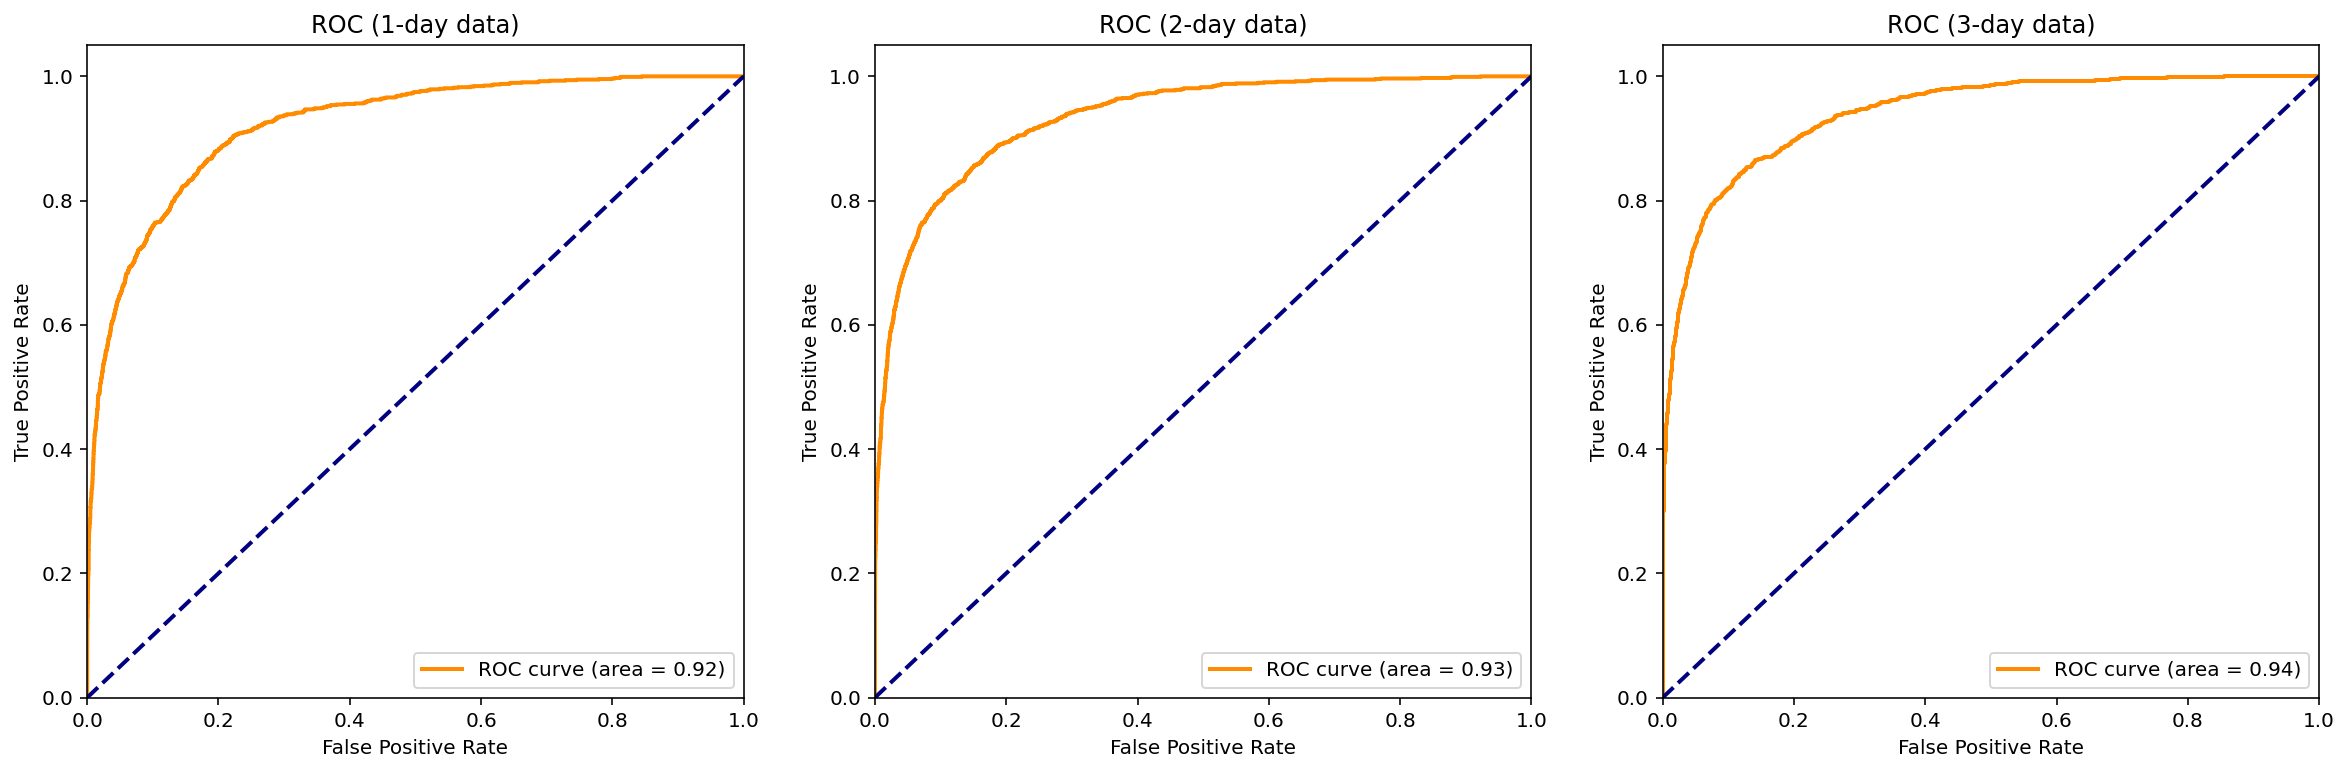

In [12]:
fig = plt.figure()
fig.set_size_inches(20,6)

plt.subplot(1,3,1)
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (1-day data)')
plt.legend(loc="lower right")

plt.subplot(1,3,2)
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (2-day data)')
plt.legend(loc="lower right")

plt.subplot(1,3,3)
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (3-day data)')
plt.legend(loc="lower right")

fig.savefig('../img/figure2.png')
plt.show()

---
## Part 4. Visualization of Feature Importance


In [13]:
# show best parameter resulted from grid search
grid_search[0].best_params_

{'algorithm__bootstrap': True,
 'algorithm__criterion': 'gini',
 'algorithm__max_depth': 30,
 'algorithm__max_features': 'auto',
 'algorithm__n_estimators': 500}

In [26]:
# load data
df_6hr = pd.read_csv('../../data/mp_data_1day.csv')

# define features
categorical_features = ['gender', 'ethnicity', 'admission_type']
numerical_features = ['age', 'icustay_num',
                       'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                       'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                       'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                       'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                       'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                       'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                       'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                       'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                       'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                       'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                       'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                       'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                       'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                       'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                       'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                       'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                       'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                       'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                       'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                       'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                       'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                       'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                       'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                       'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                       'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                       'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                       'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                       'urineoutput']
features = categorical_features + numerical_features 

# impute missing values of numerical features with median
for col in numerical_features:
    df_6hr[col].fillna(df_6hr[col].median(), inplace=True)
    
# encoding categorical features
le_gender = LabelEncoder()
df_6hr['gender'] = le_gender.fit_transform(df_6hr.gender)
le_enthnicity = LabelEncoder()
df_6hr['ethnicity'] = le_enthnicity.fit_transform(df_6hr.ethnicity)
le_admission_type = LabelEncoder()
df_6hr['admission_type'] = le_admission_type.fit_transform(df_6hr.admission_type)

# train-test split
y = df_6hr.hospital_expire_flag
X = df_6hr[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# train classifier with the best paramter set
best_params = grid_search[0].best_params_
#clf = RandomForestClassifier(n_estimators=best_params['algorithm__n_estimators'], 
#                            max_features=best_params['algorithm__max_features'],
#                            max_depth=best_params['algorithm__max_depth'],
#                            bootstrap=best_params['algorithm__bootstrap'],
#                            criterion=best_params['algorithm__criterion'],
#                            random_state=0, n_jobs=-1)
clf = XGBClassifier(random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
print("Accuracy score on training set and test set: ", clf.score(X_train, y_train), clf.score(X_test, y_test))

D:\software\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:07:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score on training set and test set:  0.9808336481551442 0.9226352372317921


Top 10 features
gcsmotor_max      0.147229
gcsverbal_max     0.106805
bun_max           0.035390
lactate_mean      0.025285
admission_type    0.019454
gcseyes_mean      0.019299
urineoutput       0.016100
albumin_min       0.015754
gcseyes_max       0.015004
bilirubin_max     0.011625
dtype: float32


<AxesSubplot:>

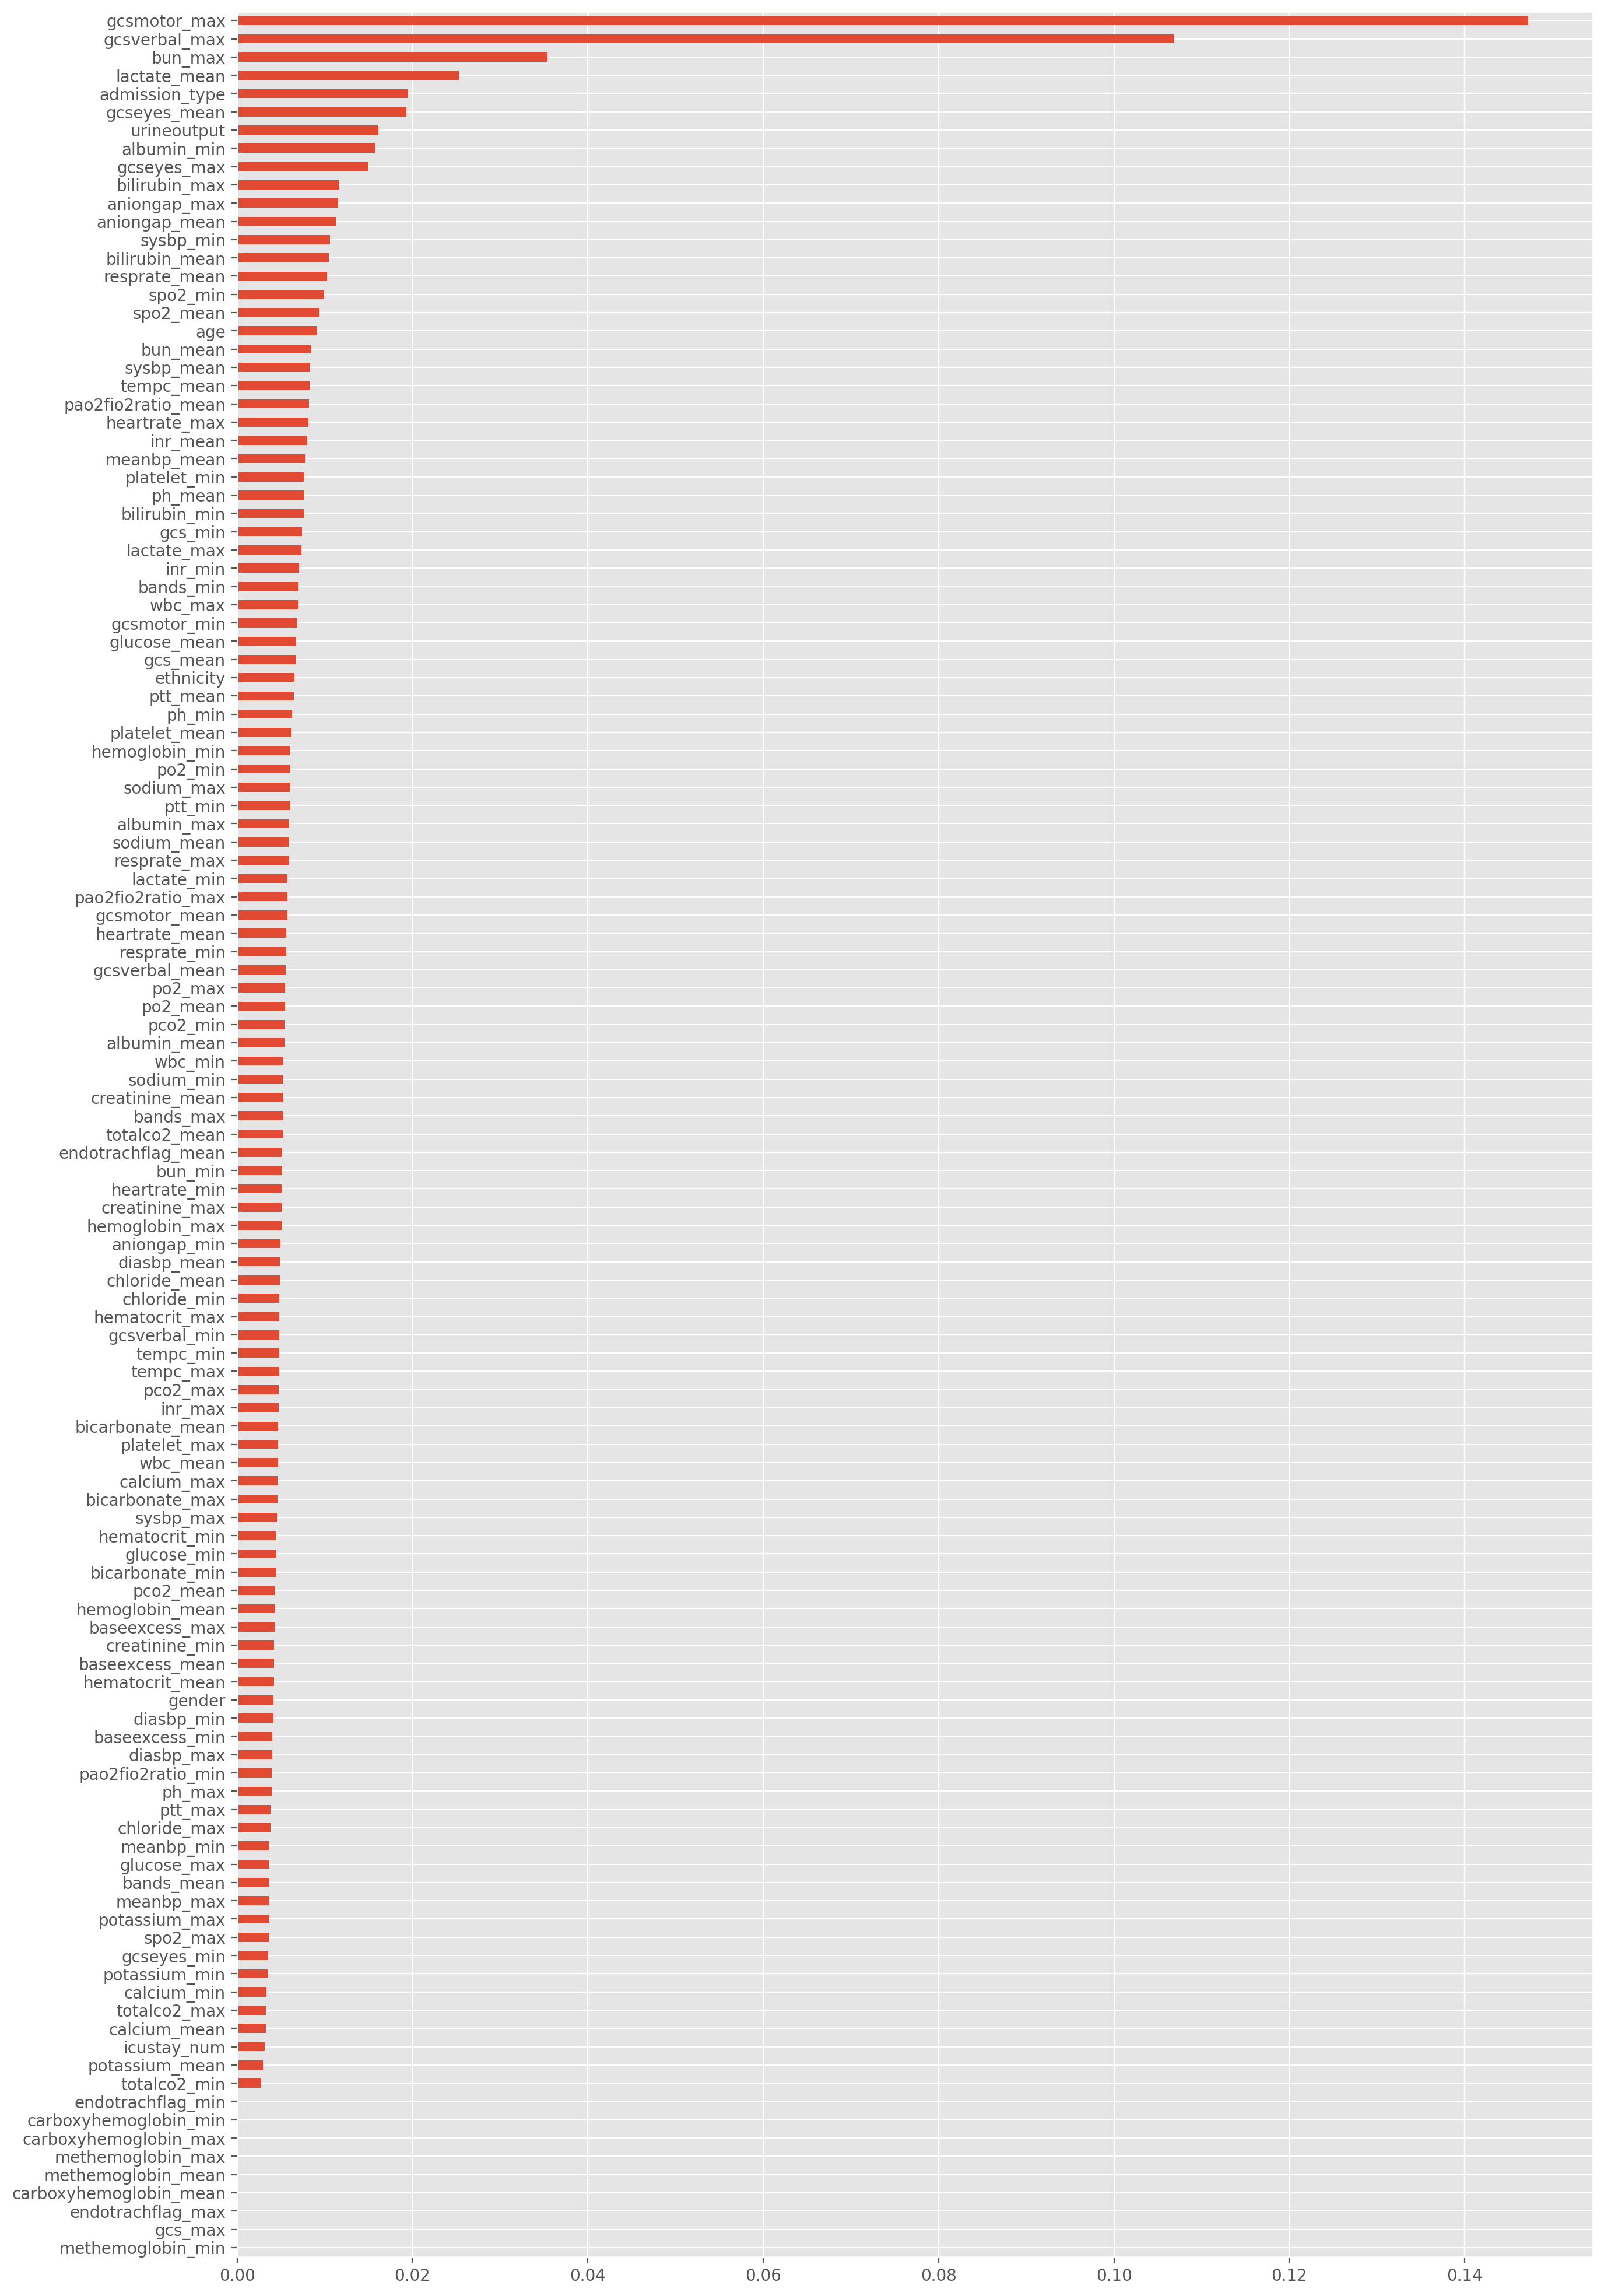

In [27]:
# plot feature importance
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(15,25)
    
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
print("Top 10 features")
print(feat_importances.nlargest(10))

feat_importances.nsmallest(123).plot(kind='barh')

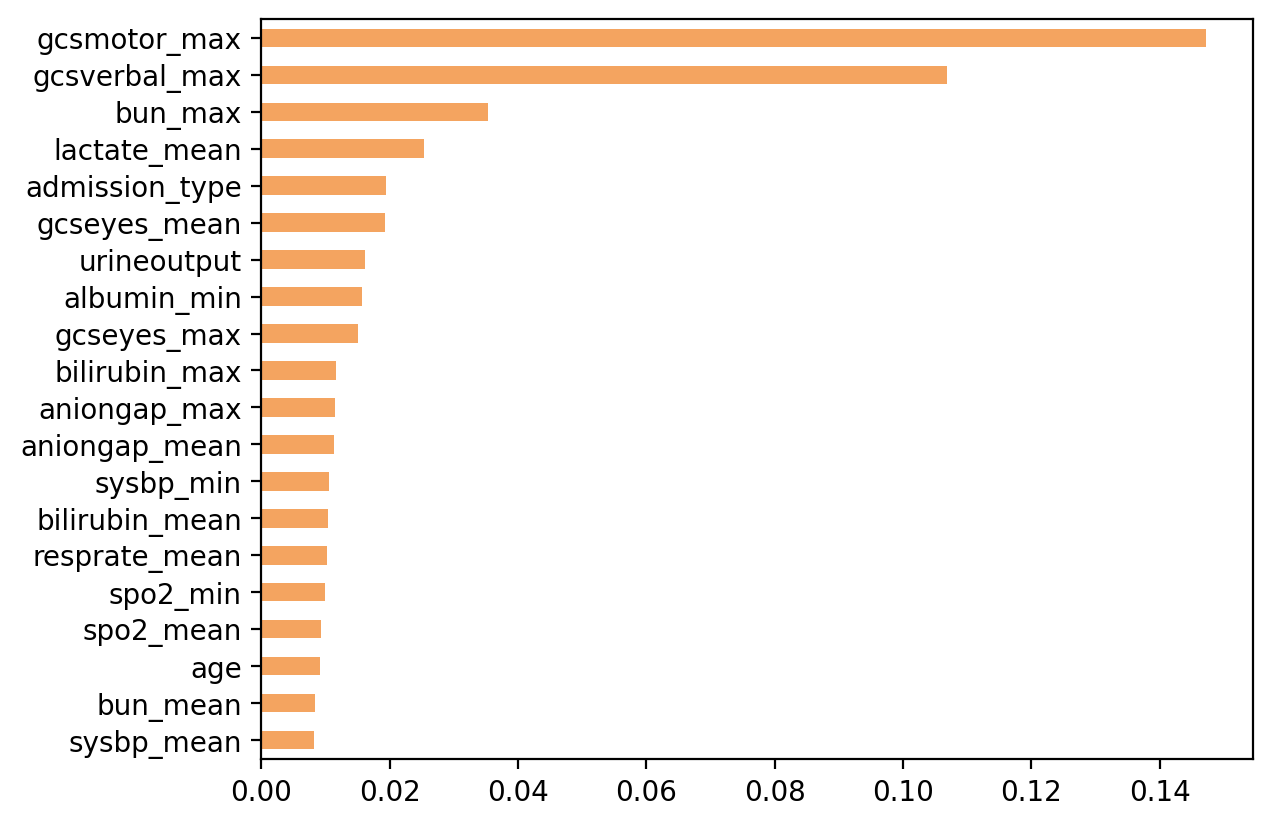

In [28]:
# plot top 20 feature importance
plt.style.use('default')
fig.set_size_inches(15,10)
fig = plt.figure()
feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh', color='sandybrown')
fig.savefig('../img/figure6.png', bbox_inches='tight', pad_inches=0.5)
plt.show()

In [17]:
# Models
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

models = dict()
#models['Dicision Tree'] = DecisionTreeClassifier(class_weight={0:1,1:2})
models['Random Forest'] = RandomForestClassifier(class_weight={0:1,1:2})
models['Logistic Regression'] = LogisticRegression()
#models['Ridge Regression'] = Ridge(alpha=1.0)
models['GradientBoost'] = GradientBoostingClassifier()
models['AdaBoost'] = AdaBoostClassifier()
models['XGBoost'] = xgboost.XGBClassifier()
models['GaussianNB']= GaussianNB(var_smoothing = 1e-9)
models['KNN'] = KNeighborsClassifier(n_neighbors=3)
models['MLP'] = MLPClassifier()

In [19]:
for model in models:
    models[model].fit(X_train, y_train)
    print(model + ' : fit')

Random Forest : fit


D:\software\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression : fit
GradientBoost : fit
AdaBoost : fit
[20:56:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\software\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBoost : fit
GaussianNB : fit
KNN : fit
MLP : fit


In [20]:
print("Train set prediction")
for x in models:
        
    print('------------------------'+x+'------------------------')
    model = models[x]
    y_train_pred = model.predict(X_train)  # X_train, X_test, y_train, y_test
    arg_train = {'y_true':y_train, 'y_pred':y_train_pred}
    print(confusion_matrix(**arg_train))
    print(classification_report(**arg_train))

Train set prediction
------------------------Random Forest------------------------
[[35051     0]
 [    0  4654]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35051
           1       1.00      1.00      1.00      4654

    accuracy                           1.00     39705
   macro avg       1.00      1.00      1.00     39705
weighted avg       1.00      1.00      1.00     39705

------------------------Logistic Regression------------------------
[[34573   478]
 [ 3680   974]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     35051
           1       0.67      0.21      0.32      4654

    accuracy                           0.90     39705
   macro avg       0.79      0.60      0.63     39705
weighted avg       0.88      0.90      0.87     39705

------------------------GradientBoost------------------------
[[34541   510]
 [ 2627  2027]]
              precision    recall  f1-sc

In [21]:
print("Test set prediction")
for x in models:
        
    print('------------------------'+x+'------------------------')
    model = models[x]
    y_test_pred = model.predict(X_test)
    arg_test = {'y_true':y_test, 'y_pred':y_test_pred}
    print(confusion_matrix(**arg_test))
    print(classification_report(**arg_test))

Test set prediction
------------------------Random Forest------------------------
[[8731   84]
 [ 742  370]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      8815
           1       0.81      0.33      0.47      1112

    accuracy                           0.92      9927
   macro avg       0.87      0.66      0.71      9927
weighted avg       0.91      0.92      0.90      9927

------------------------Logistic Regression------------------------
[[8676  139]
 [ 843  269]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      8815
           1       0.66      0.24      0.35      1112

    accuracy                           0.90      9927
   macro avg       0.79      0.61      0.65      9927
weighted avg       0.88      0.90      0.88      9927

------------------------GradientBoost------------------------
[[8648  167]
 [ 662  450]]
              precision    recall  f1-score   support

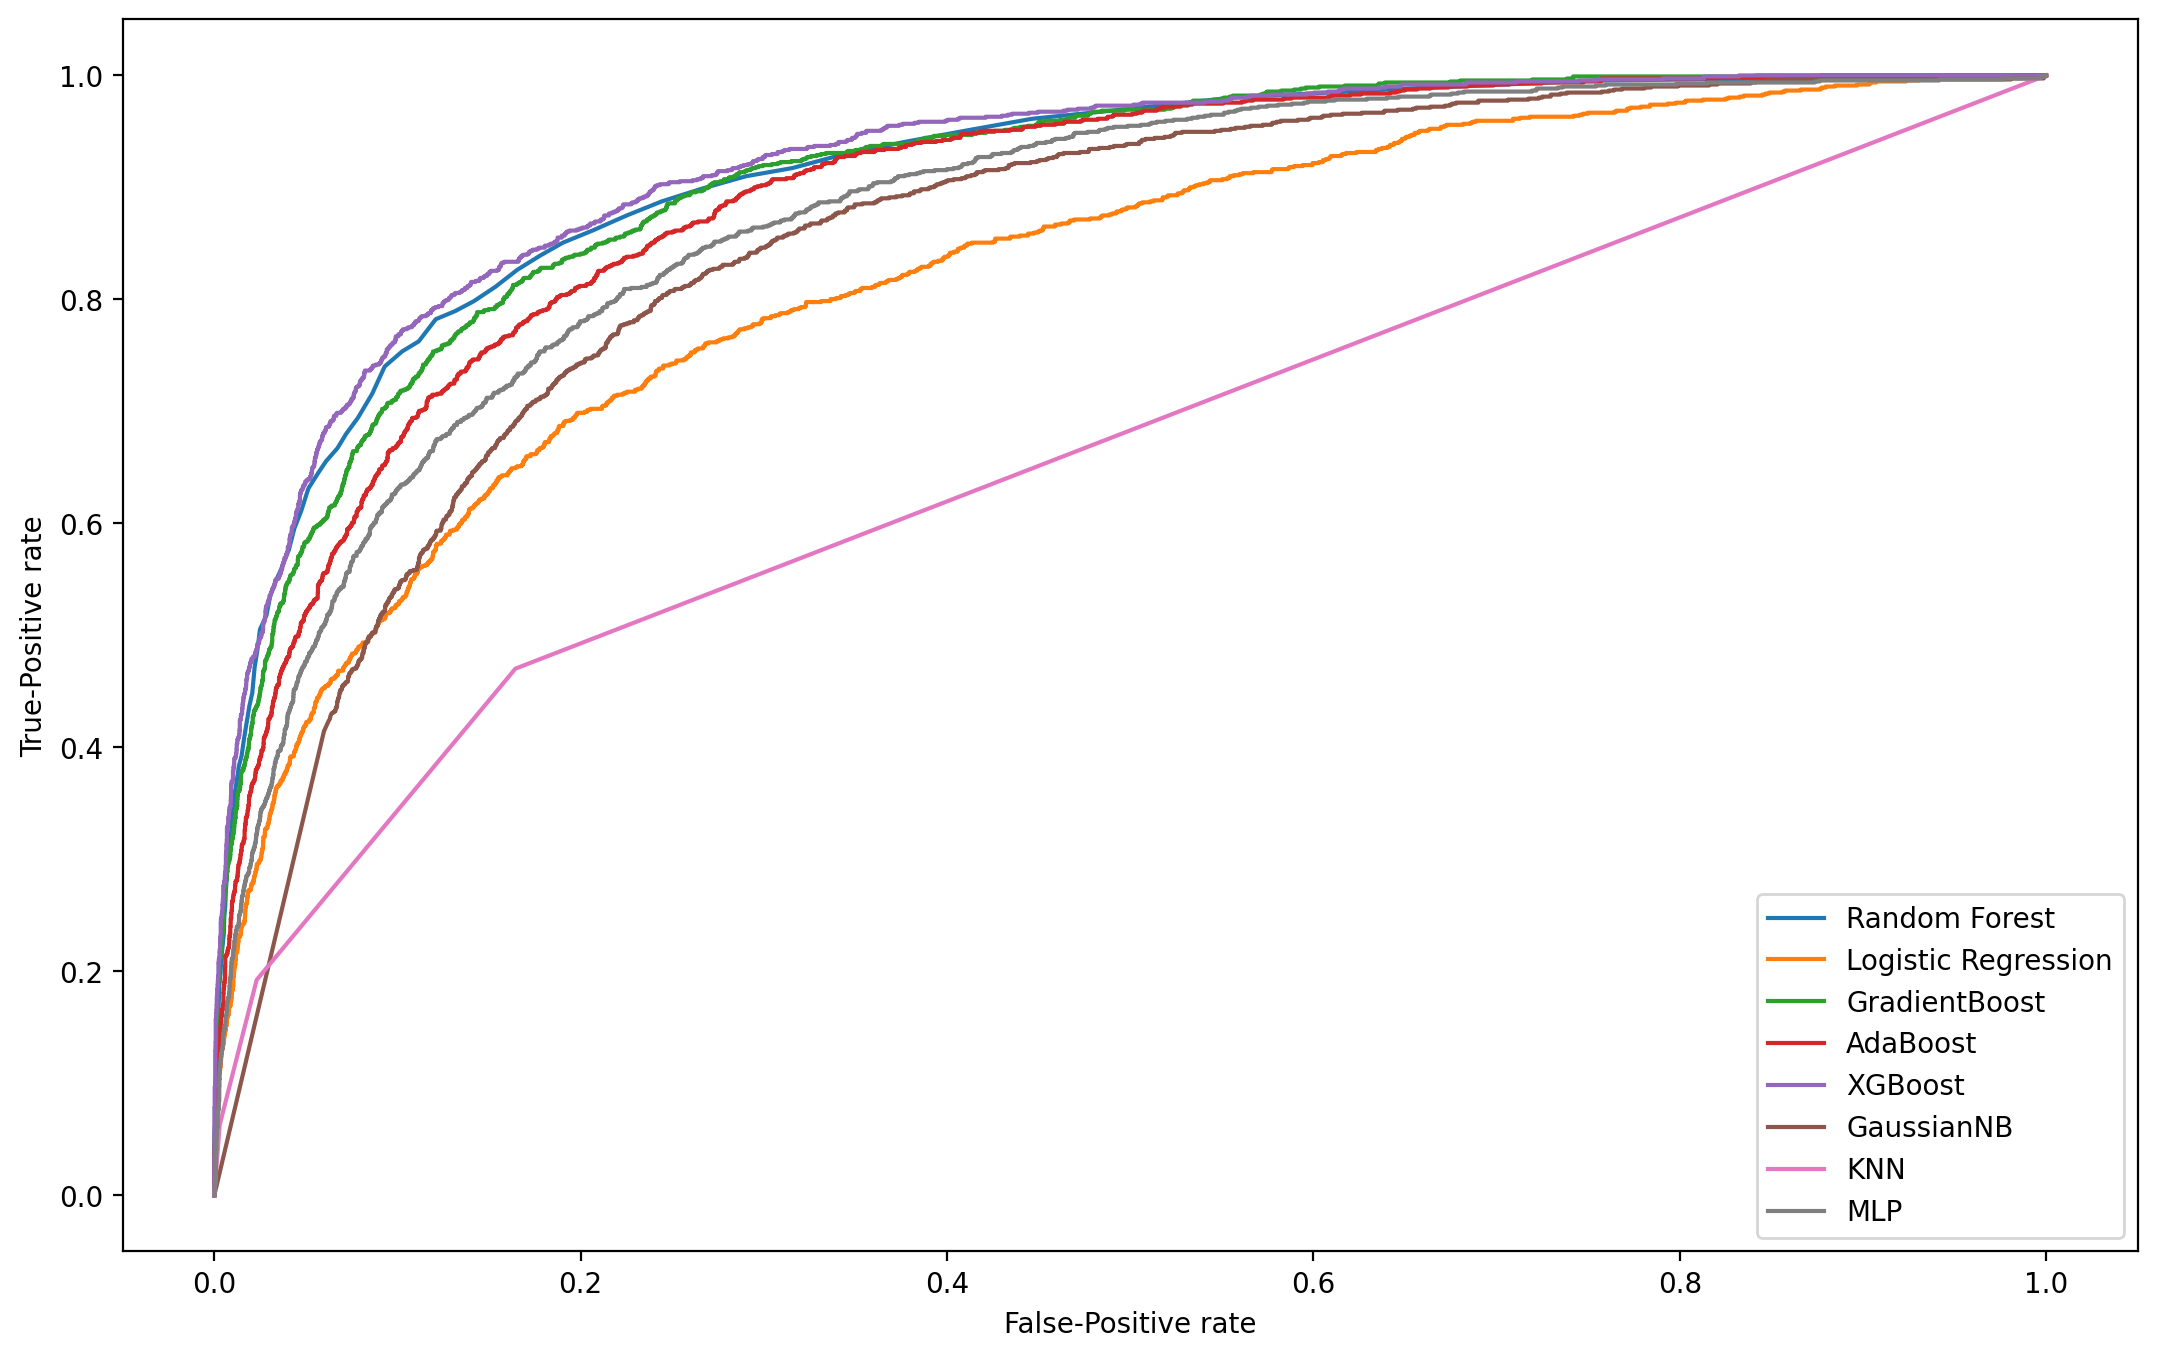

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,mean_squared_error

fig, ax = plt.subplots()
fig.set_size_inches(13,8)

for m in models:
    y_pred = models[m].predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred[:,1].ravel())
    plt.plot(fpr,tpr, label=m)
plt.xlabel('False-Positive rate')
plt.ylabel('True-Positive rate')
plt.legend()
plt.show()

In [23]:
print('roc_auc_score')
for i in models:
    model = models[i]
    print(i + ' : ',roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]).round(4))

roc_auc_score
Random Forest :  0.9117
Logistic Regression :  0.8212
GradientBoost :  0.907
AdaBoost :  0.8928
XGBoost :  0.9186
GaussianNB :  0.8473
KNN :  0.6638
MLP :  0.8733


In [24]:
print('accuracy_score')
for i in models:
    model = models[i]
    print(i + ' : ',accuracy_score(y_test, model.predict(X_test)).round(4))
    
print('RMSE')
for i in models:
    model = models[i]
    print(i + ' : ',np.sqrt(mean_squared_error(y_test, model.predict(X_test))).round(4))

accuracy_score
Random Forest :  0.9168
Logistic Regression :  0.9011
GradientBoost :  0.9165
AdaBoost :  0.9095
XGBoost :  0.9226
GaussianNB :  0.8228
KNN :  0.889
MLP :  0.8608
RMSE
Random Forest :  0.2885
Logistic Regression :  0.3145
GradientBoost :  0.289
AdaBoost :  0.3008
XGBoost :  0.2781
GaussianNB :  0.4209
KNN :  0.3332
MLP :  0.3731
